# PSB injection bump in Xsuite - track!

In [1]:
%matplotlib notebook

In [2]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xtrack as xt
import xpart as xp
import xdeps as xd

from cpymad.madx import Madx

###  Load line from previous notebook

In [3]:
# Reload
line = xt.Line.from_json('psb_05_thin.json')
line.build_tracker()
tw = line.twiss()

line.vars['t_turn_s'] = 0 # avoid leftovers from previous scripts

Loading line from dict: 100%|█| 2396/2396 [00:00<00:00, 2032


Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


In [4]:
# check kinetic energy
e_kin_inj_ev = xt.PROTON_MASS_EV * (line.particle_ref.gamma0[0] - 1)
beta0_inj = line.particle_ref.beta0[0]

print(f'Kinetic energy at injection: {1e-9 * e_kin_inj_ev:.5f} GeV (beta={beta0_inj:.5f})')

Kinetic energy at injection: 0.16000 GeV (beta=0.51975)


### Enable chicane and chicane correction

In [5]:
line.vars['on_chicane_k0'] = 1
line.vars['on_chicane_k2'] = 1
line.vars['on_chicane_beta_corr'] = 1
line.vars['on_chicane_tune_corr'] = 1

### Install monitor at foil

In [6]:
num_turns = 10000

monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns, particle_id_range=(0,50))

line.discard_tracker()
line.insert_element(index='bi1.tstr1l1', element=monitor, name='monitor_at_foil')
line.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


### Generate some test particles

In [7]:
line.vars['t_turn_s'] = 0.
p = line.build_particles(zeta=np.linspace(-45, 45, 50))

### Enable time-dependent variables (update `t_turn_s` automatically during tracking)

In [8]:
line.enable_time_dependent_vars = True
# line.dt_update_time_dependent_vars = 3e-6
line.vars.cache_active = True
line.vars['t_turn_s'] = 0.

In [9]:
print('Tracking...')
line.track(p, num_turns=num_turns, time=True, with_progress=True)
print(f'Done in {line.time_last_track:.4} s')

Tracking...


Tracking: 100%|██████| 10000/10000 [00:46<00:00, 215.50it/s]

Done in 46.41 s


<IPython.core.display.Javascript object>


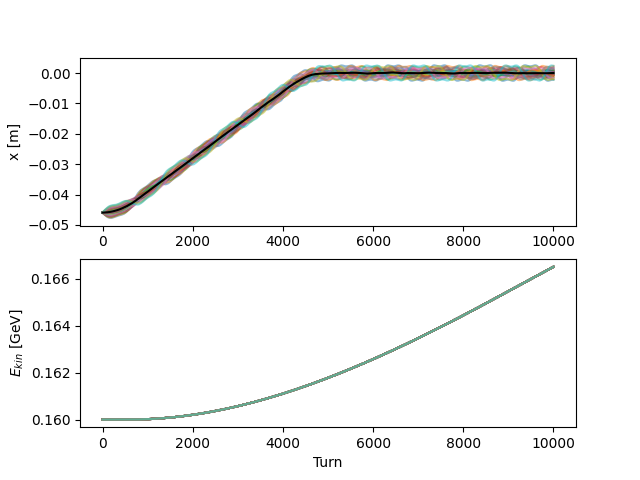

In [10]:
import matplotlib.pyplot as plt
plt.close('all')
plt.figure(1)
sp1 = plt.subplot(2,1,1)
plt.plot(monitor.x.T, alpha=0.5)
plt.plot(np.mean(monitor.x, axis=0), color='k')

plt.ylabel('x [m]')
plt.subplot(2,1,2, sharex=sp1)
plt.plot(1e-9 * xt.PROTON_MASS_EV * (monitor.gamma0.T - 1), alpha=0.5)
plt.ylabel(r'$E_{kin}$ [GeV]')
plt.xlabel('Turn')
plt.show()

<IPython.core.display.Javascript object>


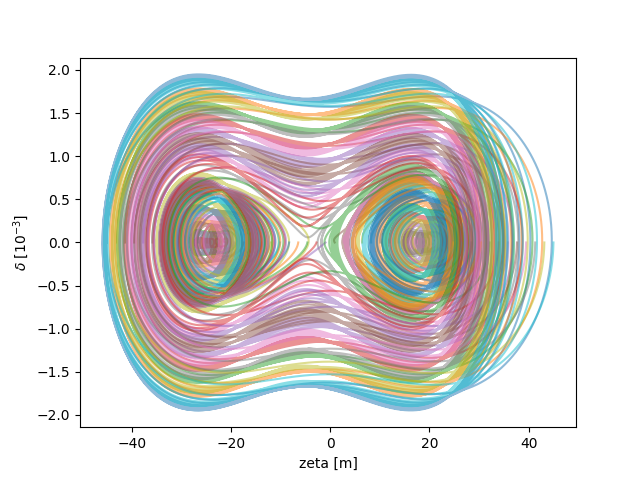

Text(0, 0.5, '$\\delta$ [$10^{-3}$]')

In [11]:
plt.figure(2)
_ = plt.plot(monitor.zeta.T, monitor.delta.T * 1e3, alpha=0.5)
plt.xlabel('zeta [m]')
plt.ylabel(r'$\delta$ [$10^{-3}$]')


### Check that revolution frequency is changing

<IPython.core.display.Javascript object>


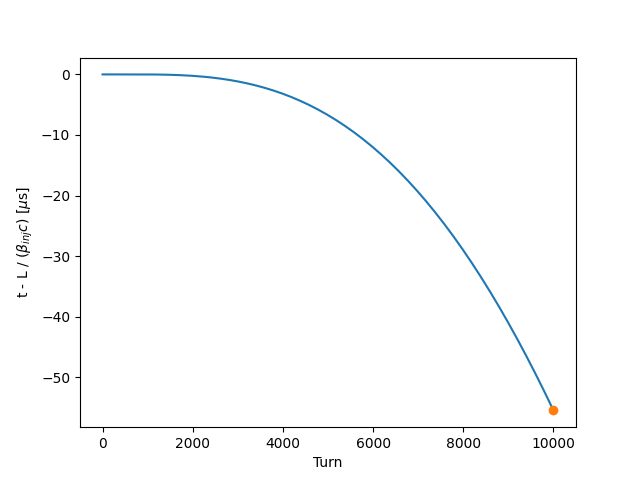

Text(0.5, 0, 'Turn')

In [12]:
from scipy.constants import c as clight

i_turn_test = np.arange(num_turns)
t_turn = line.energy_program.get_t_s_at_turn(i_turn_test)
t_turn_constant_energy = i_turn_test * line.get_length()/clight/beta0_inj

plt.figure(3)
plt.plot(i_turn_test, 1e6 * (t_turn - t_turn_constant_energy))
plt.plot(num_turns-1, 1e6 * (line.vv['t_turn_s'] - t_turn_constant_energy[-1]), 'o')

plt.ylabel(r't - L / ($\beta_{inj} c$) [$\mu$s]')
plt.xlabel('Turn')

In [ ]:
# Multiturn injection

### Load particles for multiturn injection

In [ ]:
fname = './inj_distrib.dat'
df = pd.read_table(fname, skiprows=3,
    names="x x' y y' z z' Phase Time Energy Loss".split())

kin_energy_ev = df.Energy.values * 1e6
tot_energy_ev = kin_energy_ev + xt.PROTON_MASS_EV
p0c = line.particle_ref.p0c[0]
tot_energy0_ev = line.particle_ref.energy0[0]

ptau = (tot_energy_ev - tot_energy0_ev) / p0c

# Build a particles object
part_for_injection = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV, p0c=line.particle_ref.p0c[0],
                                  ptau=ptau)

part_for_injection.x = df.x.values * 1e-3
part_for_injection.y = df.y.values * 1e-3
part_for_injection.zeta = df.z.values * 1e-3
part_for_injection.px = df["x'"].values * 1e-3 * (1 + part_for_injection.delta)
part_for_injection.py = df["y'"].values * 1e-3 * (1 + part_for_injection.delta)
part_for_injection.weight = 1e10


### Build and insert multi-turn injection element

In [ ]:
p_injection = xt.ParticlesInjectionSample(particles_to_inject=part_for_injection,
                                        line=line,
                                        element_name='injection',
                                        num_particles_to_inject=7)
line.discard_tracker()
line.insert_element(index='bi1.tstr1l1', element=p_injection, name='injection')
line.build_tracker()

### Generate particle object with unallocated space

In [ ]:
p = line.build_particles(_capacity=100, x=0)
p.state[0] = -500 # kill the particle added by default

In [ ]:
line.t_turn_s = 0 # Reset time!
intensity = []
line.enable_time_dependent_vars = True
for iturn in range(8):
    if iturn == 4:
        p_injection.num_particles_to_inject = 0 
    intensity.append(p.weight[p.state>0].sum())
    line.track(p, num_turns=1)


In [ ]:
plt.figure(4)
plt.plot(intensity, '.-')
plt.ylabel('Intensity [p+]')
plt.xlabel('Turn')

-------